Import datasets and library

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

Load training and testing datasets and preprocessing (Selecting 10000 training samples and normalizing features for zero mean and unit variance)

In [ ]:
# Define the random seed for reproducibility
np.random.seed(42)

# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images to have zero mean and unit variance
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Select 1000 examples uniformly at random out of every 5000 examples in each class for training
selected_indices = []
for class_idx in range(10):
    class_indices = np.where(np.array(trainset.targets) == class_idx)[0]
    selected_indices.extend(np.random.choice(class_indices, size=1000, replace=False))

# Create a Subset dataset with the selected indices
trainset_subset = torch.utils.data.Subset(trainset, selected_indices)

# Create the trainloader using the Subset dataset
trainloader = torch.utils.data.DataLoader(trainset_subset, batch_size=64, shuffle=True, num_workers=2)

# Load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Verify the number of training samples
print("Number of training samples:", len(trainset_subset))

100%|██████████| 170498071/170498071 [00:14<00:00, 11782980.33it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training samples: 10000


In [ ]:
# Define the ResNet18 model
resnet18_model = torchvision.models.resnet18(weights=None)
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_ftrs, 10)  # Change the last fully connected layer to have 10 output classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet18_model.parameters(), lr=0.001)

**Without Augmentation**

Epoch [1/100] - Training Loss: 1.7333 - Training Accuracy: 0.3775 - Test Accuracy: 0.4475
Epoch [2/100] - Training Loss: 1.3879 - Training Accuracy: 0.4966 - Test Accuracy: 0.5106
Epoch [3/100] - Training Loss: 1.1871 - Training Accuracy: 0.5711 - Test Accuracy: 0.5624
Epoch [4/100] - Training Loss: 1.0313 - Training Accuracy: 0.6346 - Test Accuracy: 0.5873
Epoch [5/100] - Training Loss: 0.8816 - Training Accuracy: 0.6865 - Test Accuracy: 0.5822
Epoch [6/100] - Training Loss: 0.7616 - Training Accuracy: 0.7325 - Test Accuracy: 0.5977
Epoch [7/100] - Training Loss: 0.6208 - Training Accuracy: 0.7823 - Test Accuracy: 0.5863
Epoch [8/100] - Training Loss: 0.5231 - Training Accuracy: 0.8183 - Test Accuracy: 0.5969
Epoch [9/100] - Training Loss: 0.3975 - Training Accuracy: 0.8582 - Test Accuracy: 0.6024
Epoch [10/100] - Training Loss: 0.3472 - Training Accuracy: 0.8795 - Test Accuracy: 0.6089
Epoch [11/100] - Training Loss: 0.2879 - Training Accuracy: 0.9009 - Test Accuracy: 0.6038
Epoch [1

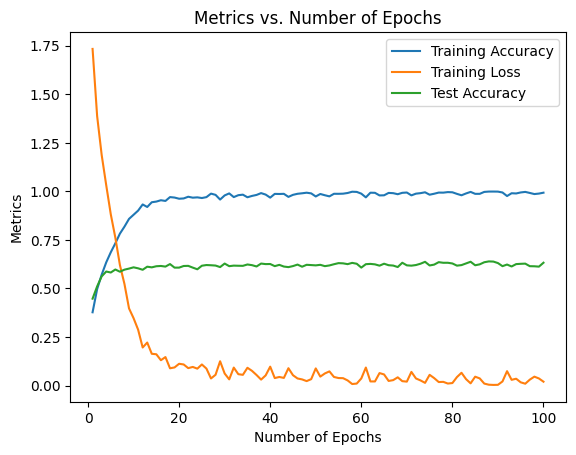

In [ ]:
# Train the model
num_epochs = 100

training_accuracy = []
training_loss = []
test_accuracy = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18_model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Accumulate the running loss
        running_loss += loss.item()

    # Calculate the average training loss and accuracy
    average_loss = running_loss / len(trainloader)
    accuracy = correct / total

    # Evaluate the model on the test set
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = correct / total

    # Append the metrics to the lists
    training_loss.append(average_loss)
    training_accuracy.append(accuracy)
    test_accuracy.append(test_acc)

    # Print the epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f} - Training Accuracy: {accuracy:.4f} - Test Accuracy: {test_acc:.4f}")

# Plotting the metrics
epochs = range(1, num_epochs+1)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, test_accuracy, label='Test Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Metrics')
plt.title('Metrics vs. Number of Epochs')
plt.legend()
plt.show()

**Mixup Augmentation**

Epoch [1/100], Training Loss: 0.9503, Training Accuracy: 0.5778, Test Accuracy: 0.3610
Epoch [2/100], Training Loss: 0.9083, Training Accuracy: 0.5941, Test Accuracy: 0.3549
Epoch [3/100], Training Loss: 0.9199, Training Accuracy: 0.5886, Test Accuracy: 0.3434
Epoch [4/100], Training Loss: 0.9048, Training Accuracy: 0.5903, Test Accuracy: 0.3409
Epoch [5/100], Training Loss: 0.8935, Training Accuracy: 0.5942, Test Accuracy: 0.3268
Epoch [6/100], Training Loss: 0.8808, Training Accuracy: 0.6077, Test Accuracy: 0.3498
Epoch [7/100], Training Loss: 0.8883, Training Accuracy: 0.5990, Test Accuracy: 0.3346
Epoch [8/100], Training Loss: 0.9020, Training Accuracy: 0.6005, Test Accuracy: 0.3717
Epoch [9/100], Training Loss: 0.9528, Training Accuracy: 0.5931, Test Accuracy: 0.3542
Epoch [10/100], Training Loss: 0.8480, Training Accuracy: 0.6230, Test Accuracy: 0.3350
Epoch [11/100], Training Loss: 0.8735, Training Accuracy: 0.6112, Test Accuracy: 0.3614
Epoch [12/100], Training Loss: 0.8684, Tr

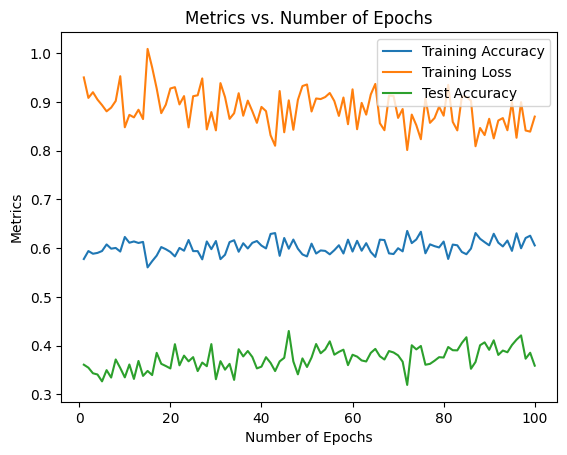

0.4301


In [ ]:
# Train the model
num_epochs = 100
training_accuracy = []
training_loss = []
test_accuracy = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18_model.to(device)


for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Permute the inputs and labels
        perm_indices = torch.randperm(inputs.size(0))
        perm_inputs = inputs[perm_indices]
        perm_labels = labels[perm_indices]

        LAMBDA = np.random.beta(0.4, 0.4)

        # Mix the permuted inputs and labels
        mixed_inputs = LAMBDA * inputs + (1 - LAMBDA) * perm_inputs
        mixed_labels = LAMBDA * labels + (1 - LAMBDA) * perm_labels
        mixed_labels = mixed_labels.to(torch.long)

        # Forward pass
        outputs = model(mixed_inputs)
        loss = criterion(outputs, mixed_labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += mixed_labels.size(0)
        correct += (predicted == mixed_labels).sum().item()

        # Accumulate the running loss
        running_loss += loss.item()

    # Calculate the average training loss and accuracy
    average_loss = running_loss / len(trainloader)
    accuracy = correct / total

    # Evaluate the model on the test set
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy.append(correct / total)
    training_accuracy.append(accuracy)
    training_loss.append(average_loss)

    # Print the metrics for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {average_loss:.4f}, Training Accuracy: {accuracy:.4f}, Test Accuracy: {test_accuracy[-1]:.4f}")

# Plotting the metrics
epochs = range(1, num_epochs+1)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, test_accuracy, label='Test Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Metrics')
plt.title('Metrics vs. Number of Epochs')
plt.legend()
plt.show()
print(max(test_accuracy))

**Cutout augmentation**

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the batch size, learning rate, number of epochs, and cutout size
batch_size = 100
lr = 0.001
num_epochs = 100
cutout_size = 16

# Define the cutout augmentation transform
class Cutout:
    def __init__(self, cutout_size):
        self.cutout_size = cutout_size

    def __call__(self, image):
        h, w = image.size(1), image.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - self.cutout_size // 2, 0, h)
        y2 = np.clip(y + self.cutout_size // 2, 0, h)
        x1 = np.clip(x - self.cutout_size // 2, 0, w)
        x2 = np.clip(x + self.cutout_size // 2, 0, w)
        mask[y1:y2, x1:x2] = 0
        mask = torch.from_numpy(mask)
        image = image * mask.unsqueeze(0)
        return image

Epoch 1/100 - Train Loss: 0.0836 - Train Acc: 97.39% - Test Acc: 62.30%
Epoch 2/100 - Train Loss: 0.0311 - Train Acc: 99.23% - Test Acc: 62.05%
Epoch 3/100 - Train Loss: 0.0276 - Train Acc: 99.37% - Test Acc: 62.19%
Epoch 4/100 - Train Loss: 0.0352 - Train Acc: 99.05% - Test Acc: 62.68%
Epoch 5/100 - Train Loss: 0.0172 - Train Acc: 99.53% - Test Acc: 63.27%
Epoch 6/100 - Train Loss: 0.0071 - Train Acc: 99.82% - Test Acc: 63.60%
Epoch 7/100 - Train Loss: 0.0107 - Train Acc: 99.70% - Test Acc: 63.13%
Epoch 8/100 - Train Loss: 0.0087 - Train Acc: 99.72% - Test Acc: 63.67%
Epoch 9/100 - Train Loss: 0.0050 - Train Acc: 99.83% - Test Acc: 63.48%
Epoch 10/100 - Train Loss: 0.0097 - Train Acc: 99.79% - Test Acc: 62.61%
Epoch 11/100 - Train Loss: 0.0180 - Train Acc: 99.42% - Test Acc: 61.77%
Epoch 12/100 - Train Loss: 0.0166 - Train Acc: 99.51% - Test Acc: 62.59%
Epoch 13/100 - Train Loss: 0.0139 - Train Acc: 99.55% - Test Acc: 62.88%
Epoch 14/100 - Train Loss: 0.0093 - Train Acc: 99.73% - Test

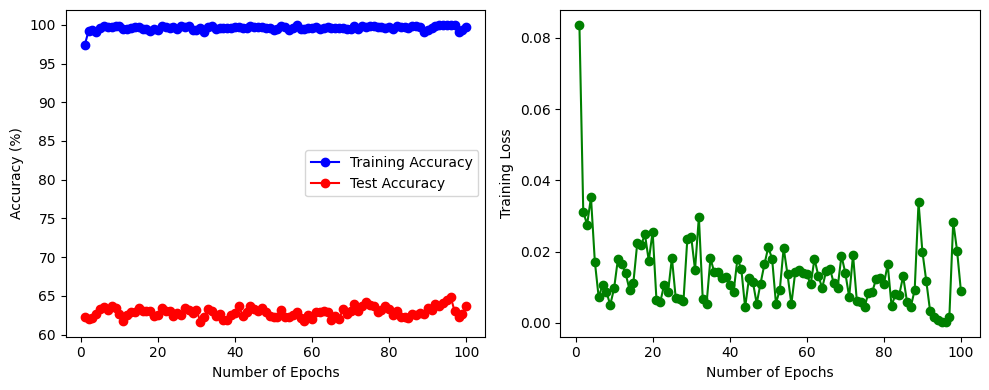

In [ ]:
# Training loop
train_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    train_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_losses.append(train_loss / len(trainloader))
    train_accs.append(100.0 * correct / total)

    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_acc = 100.0 * correct / total
    test_accs.append(test_acc)

    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - "
          f"Train Acc: {train_accs[-1]:.2f}% - Test Acc: {test_acc:.2f}%")

# Plot the results
epochs = range(1, num_epochs+1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs, 'b-o', label='Training Accuracy')
plt.plot(epochs, test_accs, 'r-o', label='Test Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'g-o')
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')

plt.tight_layout()
plt.show()

In [ ]:
print(max(test_accs))

64.56


**Standard augmentation**

In [ ]:
# Define the batch size, learning rate, number of epochs, and augmentation parameters
batch_size = 100
lr = 0.001
num_epochs = 100
augmentation_params = {
    'horizontal_flip': True,
    'vertical_flip': False,
    'random_rotation': 0,
    'random_crop': 0,
    'normalize': True
}

# Load the CIFAR-10 dataset and apply transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(augmentation_params['horizontal_flip']),
    transforms.RandomVerticalFlip(augmentation_params['vertical_flip']),
    transforms.RandomRotation(augmentation_params['random_rotation']),
    transforms.RandomCrop(32, padding=augmentation_params['random_crop']),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=test_transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18_model.to(device)

# Training loop
train_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    train_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accs.append(100.0 * correct / total)

    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_acc = 100.0 * correct / total
    test_accs.append(test_acc)

    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - "
          f"Train Acc: {train_accs[-1]:.2f}% - Test Acc: {test_acc:.2f}%")

# Plot the results
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_accs, label='Training Accuracy')
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Metrics')
plt.title('Metrics vs. Number of Epochs')
plt.legend()
plt.show()
print(max(test_accs))

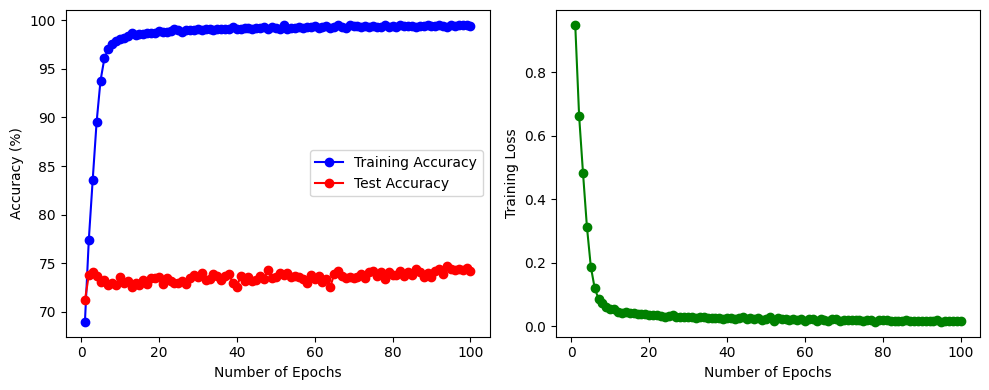

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs, 'b-o', label='Training Accuracy')
plt.plot(epochs, test_accs, 'r-o', label='Test Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'g-o')
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')

plt.tight_layout()
plt.show()

**Combine augmentation (Standard and Cutout and then mixup to blend)**

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/100 - Train Loss: 0.9643 - Train Acc: 59.62% - Test Acc: 36.78%
Epoch 2/100 - Train Loss: 0.9408 - Train Acc: 60.76% - Test Acc: 33.56%
Epoch 3/100 - Train Loss: 0.9356 - Train Acc: 59.89% - Test Acc: 35.30%
Epoch 4/100 - Train Loss: 0.9126 - Train Acc: 62.05% - Test Acc: 37.20%
Epoch 5/100 - Train Loss: 0.9316 - Train Acc: 60.27% - Test Acc: 36.02%
Epoch 6/100 - Train Loss: 0.9153 - Train Acc: 61.05% - Test Acc: 37.15%
Epoch 7/100 - Train Loss: 0.9462 - Train Acc: 60.14% - Test Acc: 36.61%
Epoch 8/100 - Train Loss: 0.9256 - Train Acc: 60.34% - Test Acc: 39.26%
Epoch 9/100 - Train Loss: 0.9178 - Train Acc: 60.40% - Test Acc: 39.55%
Epoch 10/100 - Train Loss: 0.9426 - Train Acc: 60.30% - Test Acc: 37.81%
Epoch 11/100 - Train Loss: 0.9125 - Train Acc: 61.37% - Test Acc: 39.42%
Epoch 12/100 - Train Loss: 0.9161 - Train Acc: 61.07% - Test Acc: 38.07%
Epoch 13/100 - Train Loss: 0.9133 - Train Acc: 61.54% - T

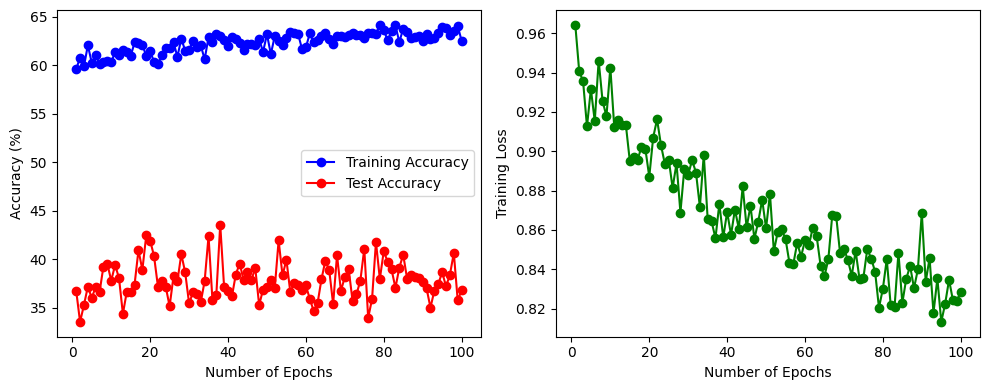

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the batch size, learning rate, number of epochs, and augmentation parameters
batch_size = 100
lr = 0.001
num_epochs = 100
augmentation_params = {
    'horizontal_flip': True,
    'vertical_flip': False,
    'random_rotation': 0,
    'random_crop': 0,
    'normalize': True
}

# Define Mixup augmentation parameters
beta_distribution_param = 0.2

# Load the CIFAR-10 dataset and apply transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(augmentation_params['horizontal_flip']),
    transforms.RandomVerticalFlip(augmentation_params['vertical_flip']),
    transforms.RandomRotation(augmentation_params['random_rotation']),
    transforms.RandomCrop(32, padding=augmentation_params['random_crop']),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    Cutout(16)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=test_transform)
# Select 1000 examples uniformly at random out of every 5000 examples in each class for training
selected_indices = []
for class_idx in range(10):
    class_indices = np.where(np.array(train_dataset.targets) == class_idx)[0]
    selected_indices.extend(np.random.choice(class_indices, size=1000, replace=False))

# Create a Subset dataset with the selected indices
trainset_subset = torch.utils.data.Subset(train_dataset, selected_indices)

# Create data loaders
train_loader = torch.utils.data.DataLoader(trainset_subset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet18_model.parameters(), lr=lr)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18_model.to(device)

# Mixup augmentation
def mixup_data(inputs, targets, alpha):
    lam = np.random.beta(alpha, alpha, inputs.size(0))
    lam = torch.from_numpy(lam).float().to(device)
    inputs = inputs * lam.view(-1, 1, 1, 1) + inputs.flip(dims=[0]) * (1 - lam.view(-1, 1, 1, 1))
    targets = targets * lam + targets.flip(dims=[0]) * (1 - lam)
    return inputs, targets

# Training loop
train_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    train_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        # Apply Mixup augmentation
        inputs, targets = mixup_data(inputs, targets, beta_distribution_param)

        outputs = model(inputs)
        targets = targets.to(torch.long)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_acc = 100.0 * correct / total
    train_accs.append(train_acc)

    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_acc = 100.0 * correct / total
    test_accs.append(test_acc)

    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - "
          f"Train Acc: {train_accs[-1]:.2f}% - Test Acc: {test_acc:.2f}%")

# Plot the results
epochs = range(1, num_epochs+1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs, 'b-o', label='Training Accuracy')
plt.plot(epochs, test_accs, 'r-o', label='Test Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'g-o')
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')

plt.tight_layout()
plt.show()

In [ ]:
print(max(test_accs))

43.58
